In [1]:
import os
os.chdir('..') # this resolves ImportError: attempted relative import with no known parent package
# import sys
# parent_dir = os.getcwd()
# sys.path.append(parent_dir)
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from src.processing.data_manipulation import single_metric_dataframes, split_into_video_series
from src.processing.feature_engineering import create_year_month_columns, create_video_counts_columns, duration_to_hhmmss

In [2]:
raw_data = pd.read_csv("data/processed/json_data_processed.csv")
data = raw_data.copy()
df = pd.DataFrame(data)
# df.sort_values(by=["publishedAt"], inplace=True)
# df.reset_index(inplace=True, drop=True)
df.head(2)

,videoID,publishedAt,channelId,title,description,channelTitle,tags,viewCount,likeCount,favoriteCount,commentCount,duration_timedelta,duration_hhmmss
0,uGtc9Bu9Txk,2020-12-31T23:00:10Z,UCArk93C2pbOvkv6jWz-3kAg,🍾 FORD KIERNAN HOGMANAY SPECIAL! | Open Goal,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'still game', 'jack ...",205682,2286,0,112,0 days 01:21:55,01:21:55
1,vAGmV-mRRT0,2020-12-24T07:00:08Z,UCArk93C2pbOvkv6jWz-3kAg,CHRISTMAS EVE SPECIAL | Right in the Coupon w/...,SUBSCRIBE to Open Goal - https://bit.ly/2QGY26...,Open Goal,"['open goal', 'si ferry', 'betting', 'slaney',...",63357,742,0,30,0 days 00:44:31,00:44:31


In [3]:
df = create_year_month_columns(df)
df = create_video_counts_columns(df)
df.head()

,videoID,publishedAt,publishedAtYear,publishedAtMonth,publishedAtYearMonth,channelTitle,channelId,title,description,duration_timedelta,duration_hhmmss,tags,viewCount,likeCount,favoriteCount,commentCount,videoCountMonth,videoCountYear
0,wA7v2RtVdSA,2017-05-26 12:49:13+00:00,2017,05,2017-05,Open Goal,UCArk93C2pbOvkv6jWz-3kAg,Open Goal Trailer,NaN,0 days 00:00:48,00:00:48,"['open goal', 'kevin thomson', ""darren o'dea"",...",8709,37,0,2,1,57
1,Fkmm0E_qgm8,2017-06-02 08:49:46+00:00,2017,06,2017-06,Open Goal,UCArk93C2pbOvkv6jWz-3kAg,Si Ferry Meets...Kevin Thomson Episode 1 - Exc...,"In Part 1 of Si Ferry Meets… Kevin Thomson, th...",0 days 00:06:45,00:06:45,"['Kevin Thomson', 'Rangers', 'Rangers Fc', 'Hi...",47975,152,0,7,21,57
2,Ks0ZO6SGlsU,2017-06-02 08:50:46+00:00,2017,06,2017-06,Open Goal,UCArk93C2pbOvkv6jWz-3kAg,Si Ferry Meets...Kevin Thomson Episode 2 - The...,Part 2 – Kevin Thomson speaks with Si about th...,0 days 00:07:23,00:07:23,"['open goal', 'si ferry', 'si ferry kevin thom...",36476,115,0,11,21,57
3,-du5xqL3YcA,2017-06-02 11:40:56+00:00,2017,06,2017-06,Open Goal,UCArk93C2pbOvkv6jWz-3kAg,Si Ferry Meets...Charlie Mulgrew Episode 1 - C...,"In Part 1 of Si Ferry Meets… Charlie Mulgrew, ...",0 days 00:07:49,00:07:49,"['Charlie Mulgrew', 'Celtic', 'Celtic fc', 'ab...",69209,240,0,7,21,57
4,mfOy5Of3Tsg,2017-06-02 11:41:08+00:00,2017,06,2017-06,Open Goal,UCArk93C2pbOvkv6jWz-3kAg,Si Ferry Meets...Charlie Mulgrew Episode 2 - A...,Part 2 – Charlie tells Si about his positive t...,0 days 00:08:32,00:08:32,"['Charlie Mulgrew', 'Celtic', 'Celtic FC', 'Ab...",54063,162,0,7,21,57


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   videoID               739 non-null    object             
 1   publishedAt           739 non-null    datetime64[ns, UTC]
 2   publishedAtYear       739 non-null    object             
 3   publishedAtMonth      739 non-null    object             
 4   publishedAtYearMonth  739 non-null    object             
 5   channelTitle          739 non-null    object             
 6   channelId             739 non-null    object             
 7   title                 739 non-null    object             
 8   description           734 non-null    object             
 9   duration_timedelta    739 non-null    object             
 10  duration_hhmmss       739 non-null    object             
 11  tags                  739 non-null    object             
 12  viewCoun

In [5]:
df['videoID'].nunique()

739

In [14]:
# group the views, likes and comment numbers by month
df_group = (
    df.groupby(by=[df['publishedAtYearMonth'], df['publishedAtYear'], df['publishedAtMonth'], 
                   df['videoCountMonth'], df['videoCountYear']])[
    ['viewCount', 'likeCount', 'commentCount']
    ]
    .sum()
    .astype(int)
    .sort_values(["publishedAtYear", "publishedAtMonth"], ascending=True)
    )

df_group.reset_index(inplace=True)

# change column order
df_group = df_group[['publishedAtYearMonth', 'publishedAtYear', 'publishedAtMonth',
             'viewCount', 'likeCount', 'commentCount',
             'videoCountMonth', 'videoCountYear']]
df_group.head(10)

,publishedAtYearMonth,publishedAtYear,publishedAtMonth,viewCount,likeCount,commentCount,videoCountMonth,videoCountYear
0,2017-05,2017,05,8709,37,2,1,57
1,2017-06,2017,06,767417,2577,87,21,57
2,2017-07,2017,07,372375,1610,64,3,57
3,2017-08,2017,08,373218,1793,80,7,57
4,2017-09,2017,09,172559,1152,37,5,57
5,2017-10,2017,10,438256,2429,134,4,57
6,2017-11,2017,11,210776,1366,82,4,57
7,2017-12,2017,12,400433,2658,105,12,57
8,2018-01,2018,01,149222,1296,93,6,92
9,2018-02,2018,02,187810,1326,71,7,92


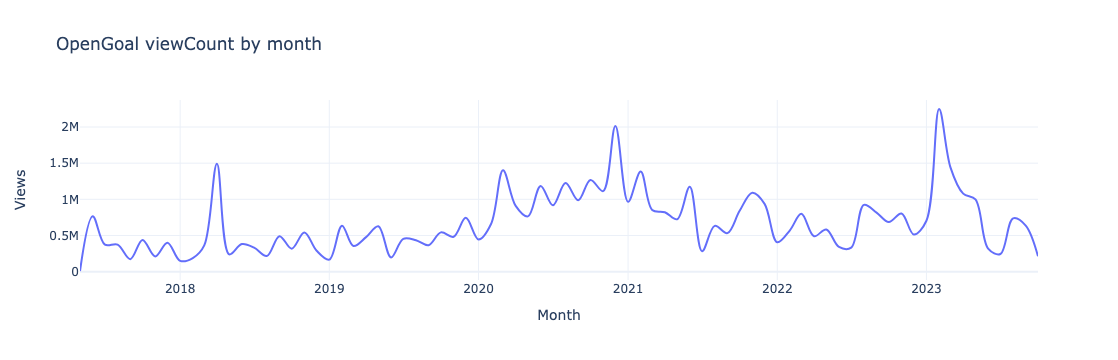

In [23]:
fig = px.line(df_group, 
              x=df_group["publishedAtYearMonth"], 
              y="viewCount",
              # color="publishedAtYear",
              # line_group="publishedAtYear",
              title='OpenGoal viewCount by month',
              line_shape='spline',
              labels={"publishedAtYearMonth": "Month", 
                      "viewCount": "Views", 
                      "likeCount": "Likes", 
                      "commentCount": "Comments"},
              # hover_name='publishedAtYearMonth',
              hover_data=["viewCount", "likeCount", "commentCount"],
              template='plotly_white',
              )
            

fig.show()